In [1]:
city='Nanjing'
city_cn='南京'

# Developer Salary in Nanjing 南京程序员工资调查
我在4月1日到3日之间，抓取了某招聘网站的软件和互联网类招聘数据40万条，其中通过程序判断为程序员的14万条。地域方面，我选择了24个主要城市。不过本文只以一线城市为研究对象。这样是为了和我2017年6月的数据做对比。

提到2017年的文章，现在居然还有很多人，把这篇文章拿出来炒作。对于社会来说，可气的是，他们直接把2017改成2019，就发表了，这不是骗人么？！对于我来说，可气的是，他们转载居然还冒充是原创，是可忍熟不可忍！

In [2]:
import pandas as pd
import sys
sys.path.append('..')
import db
import inspect
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
%matplotlib inline

In [3]:
conn=db.get_conn()
data_original=pd.read_sql(sql="select * from _51jobs where monthly_salary>0 and monthly_salary<15 and city_{}=1".format(city), con=conn)
conn.close()

In [4]:
error_job_ids=['104660258','104142922','108434795','101357291','106253516','110368302','111391233','108665401','109277048'
                  ,'73857191','108584955','102824950','102824949','111391233','110884556']
data=data_original[~data_original.job_id.isin(error_job_ids)]

In [5]:
del data['publish_date']
del data['published_on_weekend']
del data['title']
del data['company_title']
del data['company_description']
del data['job_description']
del data['job_id']

# Unilateral Stats 总体统计

有数据可知，程序员向一线城市集中的趋势非常明显。

According to the statistics, significant amount of developers are in the first tier cities.

In [6]:
salary_mean=data.monthly_salary.mean()*10000
salary_median=data.monthly_salary.median()*10000
q=np.quantile(data.monthly_salary,[0.025,0.975])*10000
print('2019年{}程序员的平均工资为{:.0f}元，工资中位数为{:.0f}元，其中95%的人的工资位于{:.0f}到{:.0f}元之间。'
      .format(city_cn,salary_mean, salary_median, q[0], q[1]))

2019年南京程序员的平均工资为12874元，工资中位数为12500元，其中95%的人的工资位于3750到27500元之间。


In [7]:
print('In 2019, Developers in {} earn {:.0f} Yuan as average, '
      'the median is {:.0f} Yuan, 95% of them earn between {:.0f} and {:.0f} Yuan.'
      .format(city,salary_mean, salary_median, q[0], q[1]))

In 2019, Developers in Nanjing earn 12874 Yuan as average, the median is 12500 Yuan, 95% of them earn between 3750 and 27500 Yuan.


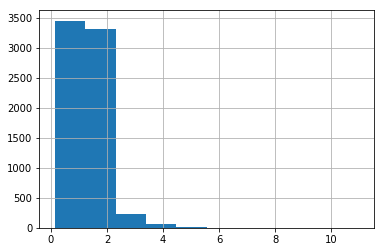

In [8]:
data.monthly_salary.hist()

It does not look like normal distribution.

In [9]:
from scipy import stats

In [10]:
stats.normaltest(data.monthly_salary)

NormaltestResult(statistic=3912.3205412634516, pvalue=0.0)

null hypothesis: x comes from a normal distribution
    
p=0

The null hypothesis can be rejected

conclusion: data is not normally distributed.

Zoom in

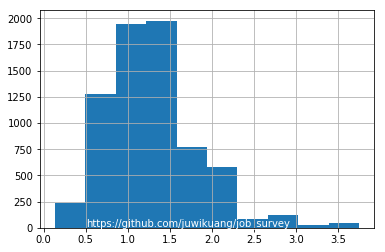

In [14]:
data[data.monthly_salary<4].monthly_salary.hist()
plt.annotate('https://github.com/juwikuang/job_survey', xy=(0,0), xytext=(0.5, 20), color='white')
plt.show()

## Role 角色

In [15]:
def get_sub_stats(data, prefix):
    
    features = [feature for feature in data.columns if feature.startswith(prefix)]
    salary_mean=[]
    salary_median=[]
    count=[]
    for feature in features:
        salary_mean.append(data[data[feature]==1].monthly_salary.mean()*10000)
        salary_median.append(data[data[feature]==1].monthly_salary.median()*10000)
        count.append(data[data[feature]==1].shape[0])
    sub_data=pd.DataFrame()
    sub_data[prefix]=[f.replace(prefix,'') for f in features]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_median']=salary_median
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)

    return sub_data

In [16]:
def add_category_column(data, prefix):
    prefix_=prefix+"_"
    features = [feature for feature in data.columns if feature.startswith(prefix)]
    data.loc[:,prefix]=['']*data.shape[0]
    for feature in features:
        data.loc[data[feature]==1,prefix]=feature.replace(prefix_,'')
    return data

In [17]:
data_career=get_sub_stats(data,'career_')
data_career.style.format({"percentage":"{:.2%}"})

,career_,salary_mean,salary_median,head_count,percentage
1,architect,19346.4,17500,258,3.57%
0,algorithm,18040.8,17500,790,10.92%
2,software_engineer,12166.3,11500,6186,85.51%


# 编程语言

In [18]:
data_pl=get_sub_stats(data,'pl_')
data_pl.style.format({"percentage":"{:.2%}"})

,pl_,salary_mean,salary_median,head_count,percentage
11,lua,18704.1,15000,49,0.54%
19,scala,18640.8,16500,71,0.79%
6,haskell,17500,17500,1,0.01%
17,ruby,16091.1,14000,32,0.36%
25,r,15916.7,14000,23,0.26%
18,rust,15321.4,13500,7,0.08%
4,go,15197.1,14583.3,480,5.34%
12,matlab,15042.9,15000,140,1.56%
16,python,14977.2,14000,802,8.92%
5,groovy,14666.7,13000,3,0.03%


数据显示，haskell才是最赚钱的编程语言。python是主流语言里面最赚钱的，比java的工资多了3000元！vb是最不赚钱的了。其中，最赚钱的编程语言和最不赚钱的，工资居然差了2倍。所以，要选好编程语言呀！

# 教育

In [19]:
data_edu=get_sub_stats(data,'edu_')
data_edu.style.format({"percentage":"{:.2%}"})

,edu_,salary_mean,salary_median,head_count,percentage
5,phd,34305.6,37500,9,0.15%
3,master,17301.2,17500,267,4.44%
1,bachelor,13548.1,12500,4050,67.39%
0,associate,10455.9,10000,1678,27.92%
2,high_school,9350,7000,5,0.08%
4,middle_school,9000,9000,1,0.02%


In [20]:
salary_phd=data[data.edu_phd==1].monthly_salary * 10000
salary_master=data[data.edu_master==1].monthly_salary * 10000
salary_bachelor=data[data.edu_bachelor==1].monthly_salary * 10000
salary_associate=data[data.edu_associate==1].monthly_salary * 10000

In [21]:
print('大专，本科，硕士，博士的平均工资分别是{:.0f}，{:.0f}，{:.0f}，{:.0f}。中位数分别是{:.0f}， {:.0f}，{:.0f}， {:.0f}。'.format(
    salary_associate.mean(),salary_bachelor.mean(),salary_master.mean(),salary_phd.mean(),
    salary_associate.median(),salary_bachelor.median(),salary_master.median(),salary_phd.median()))

大专，本科，硕士，博士的平均工资分别是10456，13548，17301，34306。中位数分别是10000， 12500，17500， 37500。


In [22]:
stats.f_oneway(salary_phd, salary_master)

F_onewayResult(statistic=38.585023359430714, pvalue=1.9390733172835053e-09)

In [23]:
stats.f_oneway(salary_master, salary_bachelor)

F_onewayResult(statistic=95.60033356433718, pvalue=2.3949217533503604e-22)

In [24]:
stats.f_oneway(salary_bachelor, salary_associate)

F_onewayResult(statistic=363.36224927786384, pvalue=1.3590274262634433e-78)

经过Oneway Anova Test，证明从大专到博士，学历每提高一级，工资都有显著的提高。

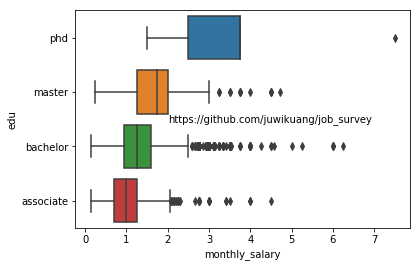

In [25]:
data=add_category_column(data,'edu')
order=['phd','master','bachelor','associate']
a=sns.boxplot(y='edu',x='monthly_salary',order=order,data=data[data.edu.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(0.5,1.5), xytext=(2, 1.55))
plt.show()

# 工作经验 Working Experience

In [26]:
data_experience=get_sub_stats(data,'experience_')
data_experience.style.format({"percentage":"{:.2%}"})

,experience_,salary_mean,salary_median,head_count,percentage
0,10,27460.8,25000,17,0.24%
3,5_10,19196.5,17500,670,9.45%
2,3_5,14159.6,12500,1977,27.88%
4,no,11584.7,10833.3,1949,27.49%
1,1_3,11053.5,10416.7,2478,34.95%


In [27]:
salary_we_10=data[data.experience_10==1].monthly_salary * 10000
salary_we_5_10=data[data.experience_5_10==1].monthly_salary * 10000
salary_we_3_5=data[data.experience_3_5==1].monthly_salary * 10000
salary_we_1_3=data[data.experience_1_3==1].monthly_salary * 10000
salary_we_no=data[data.experience_no==1].monthly_salary * 10000

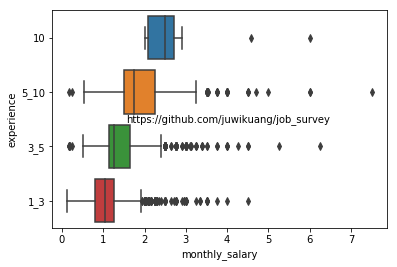

In [28]:
data=add_category_column(data,'experience')
order=['10','5_10','3_5','1_3']
sns.boxplot(y='experience',x='monthly_salary',order=order,data=data[data.experience.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(1.5,1.5), xytext=(1.55, 1.55))
plt.show()

# 公司 Company

## 公司性质 Company Type

In [29]:
data_company_type=get_sub_stats(data,'company_type_')
data_company_type.style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,company_type_,salary_mean,salary_median,head_count,percentage
9,us_eu,15029,14000,218,3.25%
6,public_institution,14367,13000,61,0.91%
8,state,13393,12500,475,7.08%
3,listed,13321,12500,622,9.27%
7,startup,13113,12500,182,2.71%
5,private,12634,12000,4999,74.52%
0,foreign,11629,12500,148,2.21%
2,foreign_rep,6000,2500,3,0.04%
1,foreign_gov,nan,nan,0,0.00%
4,non_profit,nan,nan,0,0.00%


us_eu是欧美外企，startup是创业公司，listed是上市公司，state是国企，private是私企，foreign是非欧美外企，其他不足1000个样本的不管了。

## 公司规模 Company Size

In [30]:
data_company_size=get_sub_stats(data,'company_size_')
data_company_size.style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,company_size_,salary_mean,salary_median,head_count,percentage
0,10000,17824,15000,209,2.96%
4,5000_10000,14656,14000,131,1.85%
1,1000_5000,14212,12500,818,11.58%
5,500_1000,13797,12500,673,9.52%
2,150_500,12692,12000,1665,23.56%
6,50_150,12359,11500,2315,32.76%
3,50,11694,11000,1255,17.76%


公司越大，工资越高

## 行业 Industry

In [31]:
data_industry=get_sub_stats(data,'industry_')
data_industry.style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,industry_,salary_mean,salary_median,head_count,percentage
4,finance,14713,12500,168,2.00%
8,realestate,14316,12500,183,2.17%
10,trade,13320,12500,472,5.61%
6,logistic,13242,12500,123,1.46%
2,edu,13130,12500,414,4.92%
1,computer,12880,12500,6274,74.54%
9,service,12490,12500,24,0.29%
3,energy,12482,11500,299,3.55%
5,gov,11667,10000,164,1.95%
7,medical,11586,11500,213,2.53%
